## Offshore wind resource sparse sampling using Gaussian Mixture Models

This notebook is an exemple for the implementation of Gaussian Mixture Models for the sparse sampling of offshore wind resource. Exemple is shown on the Mediterranean Sea

In [59]:
from data.EOF import compute_EOFs, eofs_2d_to_1d
from data.read_data import read_from_nc_files, process_lat_lon, process_time_index
from plots.map_plots import plot_EOF, plot_sensors_locations
from models.QR_pivot import qr_pivots
from models.GMM import fit_gmm_and_extract_centroids
from scoring.reconstruction import wind_reconstruction_from_index
from scoring.scores import score_reconstructed
import xarray as xr
import numpy as np
import pandas as pd
from models.EOF_extrema import select_eofs_exrtrema
import scipy
from sklearn import mixture
import random


#### Read and prepare data

Read data from nc files, mask land points and compute the EOFs

In [2]:
#Read data from file.
years = ['2016', '2017', '2018']
wind_speed, df_med, lat, lon, mask = read_from_nc_files(years)
time_index = process_time_index(years)
df_med.index = time_index

idx_train = time_index.year < 2018
idx_test = time_index.year >= 2018

In [3]:
lat_flat, lon_flat, mask_flat, df_latlon = process_lat_lon(lat, lon, mask)

In [4]:
#Compute EOFs
EOF_results = compute_EOFs(wind_speed['u'], wind_speed['v'], lat, lon, mask, idx_train, idx_test, N_eofs = 10)

In [5]:
EOFs_u = EOF_results['EOFs_u']
EOFs_v = EOF_results['EOFs_v']
EOFs = np.vstack((EOFs_u, EOFs_v))
V_svd = pd.concat([pd.DataFrame(EOFs_u.T), pd.DataFrame(EOFs_v.T)], axis = 1)

Visualize EOFs 

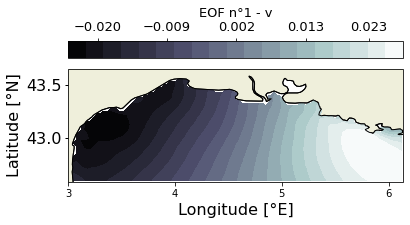

In [6]:
plot_EOF(EOFs_v, lat_flat, lon_flat, 1, 'v')

### Compute sensors placement from EOFs extrema

From Yildirim et al. (2009), selection of the EOFs extrema as salient points for sparse sampling - manual process

In [7]:
#Extrema manually selected to avoid repetitions. For EOFs from 1 to 5 for u and v, the maximum and minimum of the EOFs can be selected

#Selected extrema on the Mediterranean Sea
extrema_u_med = {1 : {'max' : 1, 'min' : 1}, 2 : {'max' : 1, 'min' : 0}, 3 : {'max' : 1, 'min' : 0}, 4 : {'max' : 1, 'min' : 0}, 5 : {'max' : 0, 'min' : 0}}
extrema_v_med = {1 : {'max' : 1, 'min' : 1}, 2 : {'max' : 0, 'min' : 1}, 3 : {'max' : 1, 'min' : 1}, 4 : {'max' : 0, 'min' : 0}, 5 : {'max' : 0, 'min' : 0}}
extrema_med = {'u' : extrema_u_med, 'v' : extrema_v_med}
n_sensors = 7

In [8]:
eofs_extrema_sensors_tot = select_eofs_exrtrema(EOFs_u, EOFs_v, extrema_med)
eofs_extrema_sensors = eofs_extrema_sensors_tot[:n_sensors]

### Compute QR pivoting sparse sampling

From (.......), selection of the pivots from the QR decomposition of the EOFs matrix as salient points for sparse sampling

In [9]:
qr_pivots_sensors = qr_pivots(EOFs, n_sensors)

### Compute Gaussian Mixture Model sparse sampling

The proposed model uses unsupervised clustering using Gaussian Mixture Models to perform sparse sampling. After fitting a GMM on the EOFs data, the clusters' centroids are selected as sensors locations

In [10]:
gmm_sensors = fit_gmm_and_extract_centroids(EOFs, n_clusters = n_sensors, random_state = random.randint(0, 100))

Visualize derived sensors positions

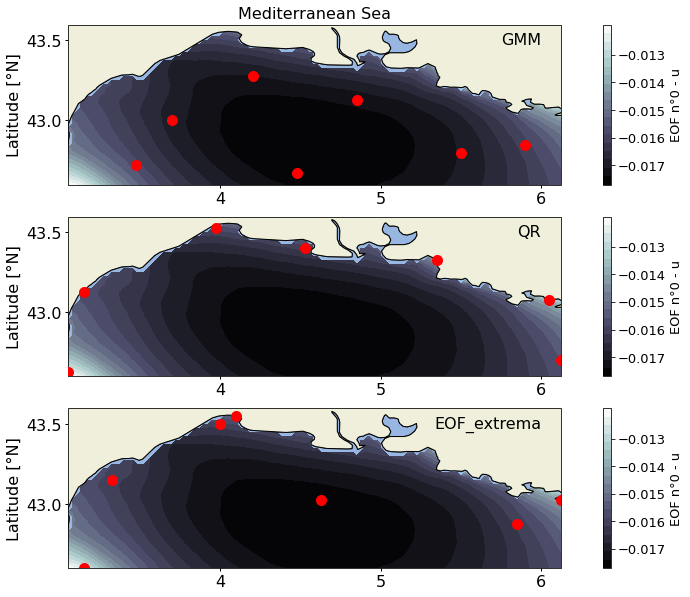

In [11]:
idx_sensors = {'GMM': gmm_sensors, 'QR': qr_pivots_sensors, 'EOF_extrema': eofs_extrema_sensors}
plot_sensors_locations(lon_flat, lat_flat, idx_sensors, EOFs, n_eof = 0)

### Scoring

The reconstruction error is defined as the Root Mean Squared Error of the reconstructed wind field from limited measurements

In [12]:
n_inputs_points = df_latlon.shape[0]

#Repeat indexes to extract both zonal and meridional wind speed
for idx in gmm_sensors : 
    gmm_sensors = np.append(gmm_sensors, idx + n_inputs_points)
for idx in qr_pivots_sensors : 
    qr_pivots_sensors = np.append(qr_pivots_sensors, idx + n_inputs_points)
for idx in eofs_extrema_sensors : 
    eofs_extrema_sensors = np.append(eofs_extrema_sensors, idx + n_inputs_points)

In [54]:
#Least Squares reconstruction of wind speed from the sensors' index

X_pred_test_gmm, X_true_test = wind_reconstruction_from_index(df_med, EOFs, gmm_sensors, idx_train, idx_test)
X_pred_test_qr, X_true_test = wind_reconstruction_from_index(df_med, EOFs, qr_pivots_sensors, idx_train, idx_test)
X_pred_test_extrema, X_true_test = wind_reconstruction_from_index(df_med, EOFs, eofs_extrema_sensors, idx_train, idx_test)

In [65]:
#Compute error metrics, mean RMSE, RMSE of wind magnitude, RMSE of maximum wind speed and RMSE of mean wind speed

err_umag_gmm, err_uv_gmm, err_umax_gmm, err_umean_gmm = score_reconstructed(X_pred_test_gmm, X_true_test)
err_umag_qr, err_uv_qr, err_umax_qr, err_umean_qr = score_reconstructed(X_pred_test_qr, X_true_test)
err_umag_extrema, err_uv_extrema, err_umax_extrema, err_umean_extrema = score_reconstructed(X_pred_test_extrema, X_true_test)

print(f'GMM reconstruction error = {err_uv_gmm} m/s')
print(f'QR pivots reconstruction error = {err_uv_qr} m/s')
print(f'EOFs extrema reconstruction error = {err_uv_extrema} m/s')

GMM reconstruction error = 0.9825921058654785 m/s
QR pivots reconstruction error = 1.783623456954956 m/s
EOFs extrema reconstruction error = 1.3829342126846313 m/s


### Select optimal number of sensors

To select the optimal number of sensors, the BIC score is computed for a range of number of clusrters. Then an error threshold is defined.